In [17]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim
import healpy as hp
from pylab import cm as cmaps
from estimator_wholesky import get_vector_alm
from tqdm import *
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
max_sep = 15
nside = 128
lmax = 3*nside - 1
nsim = 1

sim = []

for isim in tqdm_notebook(range(nsim)):
#     sim.append(QuasarSim(n_sh=1, sh_m_frac=0.2, max_sep=max_sep, m_delta=1e8*M_s, verbose=True, sh_distrib='MW', sim_uniform=True, nside=nside, 
#                          custom_coords=[[0*u.deg],[0*u.deg],[6*u.mas/u.year],[3*u.mas/u.year],[100*kpc]], calc_powerspecs=True, do_alpha=True))
#     sim.append(QuasarSim(n_sh=1, sh_m_frac=0.2, sh_profile="Plummer", max_sep=max_sep, m_delta=1e8*M_s, verbose=True, sh_distrib='MW', sim_uniform=True, nside=nside, 
#                          custom_coords=[[0*u.deg,90*u.deg,],[0*u.deg, 0*u.deg],[10*u.mas/u.year,10*u.mas/u.year],[3*u.mas/u.year, 3*u.mas/u.year],[10*kpc, 10*kpc]], do_alpha=True, calc_powerspecs=True))

#     sim.append(QuasarSim(sh_m_frac=0.2, max_sep=max_sep, m_delta=1e8*M_s, verbose=True, sh_distrib='MW', sim_uniform=True, nside=nside, c200_delta=10000, save_powerspecs=True))
    sim.append(QuasarSim(alpha_m=1.9, n_calib=300, max_sep=max_sep, verbose=True, sh_distrib='Aq1', m_min=1e-6, m_max=1e-1, sim_uniform=True, nside=nside, calc_powerspecs=True, do_alpha=True, sh_profile="Plummer"))
    
    
    

In [116]:
np.sum(sim[0].m_sample/M_s)/1e12

0.11958748798634883

In [102]:
dndm = lambda m: m**-1.9
from scipy.integrate import quad


(4.422301899621065e-06, 5.211900881972992e-09)

In [111]:
norm = (150/quad(lambda m: dndm(m), 1e8,1e10)[0])

In [112]:
norm* quad(lambda m: dndm(m), 1e6,1e10)[0]

9614.360069584087

In [78]:
cmap = cmaps.Greys
cmap.set_under('w')

In [91]:
maxx = 10**(-4.)
maxx_a = 10**(-10.5)

In [93]:
# for i in range((nsim)):

#     hp.mollview(1e6*sim[i].mu_qsrs[:,0],max=maxx, min=-maxx, title="$\mu_l$", unit='$\mu$as/yr', cmap=cmap)
#     plt.savefig("mu_l.pdf")
#     hp.mollview(1e6*sim[i].mu_qsrs[:,1],max=maxx, min=-maxx, title="$\mu_b$", unit='$\mu$as/yr', cmap=cmap)
#     plt.savefig("mu_b.pdf")
#     hp.mollview(1e6*sim[i].alpha_qsrs[:,0],max=maxx_a, min=-maxx_a, title="$\\alpha_l$", unit='$\mu$as/yr$^2$', cmap=cmap)
#     plt.savefig("alpha_l.pdf")
#     hp.mollview(1e6*sim[i].alpha_qsrs[:,1],max=maxx_a, min=-maxx_a, title="$\\alpha_b$", unit='$\mu$as/yr$^2$', cmap=cmap)
#     plt.savefig("alpha_b.pdf")

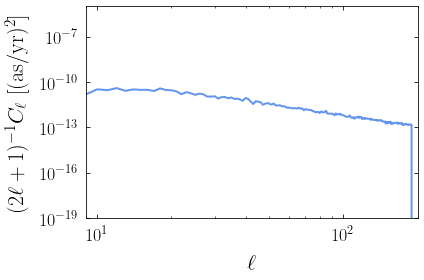

In [83]:
ell = np.arange(len(sim[0].Cl_B))

plt.plot(ell, (sim[0].Cl_B)/(2*ell + 1)/1e-12)
# plt.plot(ell, sim[0].Cl_C/(2*ell + 1)/1e-12)

# ells, Cl = bin_cells(sim[0].Cl_B/(2*ell + 1)/1e-12, 1, np.max(ell)+1, 20)
# plt.plot(ells, Cl)

# plt.plot(ell, sim[0].Cl_B_alpha/(2*ell + 1)/1e-12)
# plt.plot(ell, sim[0].Cl_C_alpha/(2*ell + 1)/1e-12)

# plt.plot(ell, (sim[0].Cl_B_mu_alpha)/(2*ell + 1)/1e-12)
# plt.plot(ell, (sim[0].Cl_C_mu_alpha)/(2*ell + 1)/1e-12)

plt.yscale("log")
plt.xscale("log")
plt.xlim(9, 200)
plt.ylim(1e-19,1e-5)
plt.ylabel("$(2\ell + 1)^{-1} C_\ell$ [(as/yr)$^2$]")
plt.xlabel("$\ell$")
# plt.legend(title='Distance to lens')
# plt.title('Gaussian lens, $R_0$ = 1 kpc, $M_0 = 10^8\,\mathrm{M}_\odot$, $\dot\\theta$ = 1 mas/yr')
plt.tight_layout()
# plt.savefig("Gauss.pdf")

In [84]:
lmin_plot = 0
lmax_plot = 300

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$\\log_{10}(\\Psi_{lm}\\,[mas/yr])$')

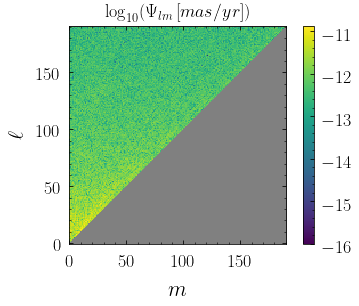

In [85]:
plt.imshow((np.log10(np.abs(sim[i].fB)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), origin='lower', vmin=-16)
cbar = plt.colorbar()

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title("$\log_{10}(\Psi_{lm}\,[mas/yr])$")

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


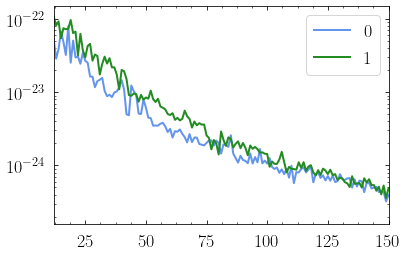

In [86]:
nch = 2
ch = np.transpose([[np.mean(split_ary) for split_ary in np.array_split((np.abs(sim[i].fB)**2)[l][:l], nch)] for l in range(lmax)])
ell = np.arange(len(ch[0]))

for ich in range(nch):
    plt.plot(ell, 2*ch[ich], label=str(ich))
# plt.plot(ell, 1e6*Cl_tot[1:]*ell*(ell+1), label="Tot", color='grey', alpha=0.9)

plt.legend()
plt.xlim((180/max_sep), 150)
# plt.ylim(1e-32,1e-27)
# plt.xscale("log")
plt.yscale("log")